<a href="https://colab.research.google.com/github/tvml/ml2425/blob/master/codici/linregr_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Regressione lineare con gradiente e sperimentazione per vari valori del coefficiente $\alpha$ nel gradiente

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [8]:
import warnings
warnings.filterwarnings('ignore')

Definizioni relative alla visualizzazione

In [3]:
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 
          'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

In [9]:
import urllib.request

filepath = "../dataset/"
url = "https://tvml.github.io/ml2425/dataset/"

def get_file(filename):
    IS_COLAB = ('google.colab' in str(get_ipython()))
    if IS_COLAB:
        urllib.request.urlretrieve (url+filename, filename)
        return filename
    else:
        return filepath+filename

Funzione di normalizzazione

In [5]:
def normalizza(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    return (X-mu)/sigma

Legge i dati in dataframe pandas

In [10]:
# legge i dati in dataframe pandas
data = pd.read_csv(get_file("mammals.csv"), delimiter=',')

# calcola dimensione dei dati
n = len(data)

Visualizza il dataset.

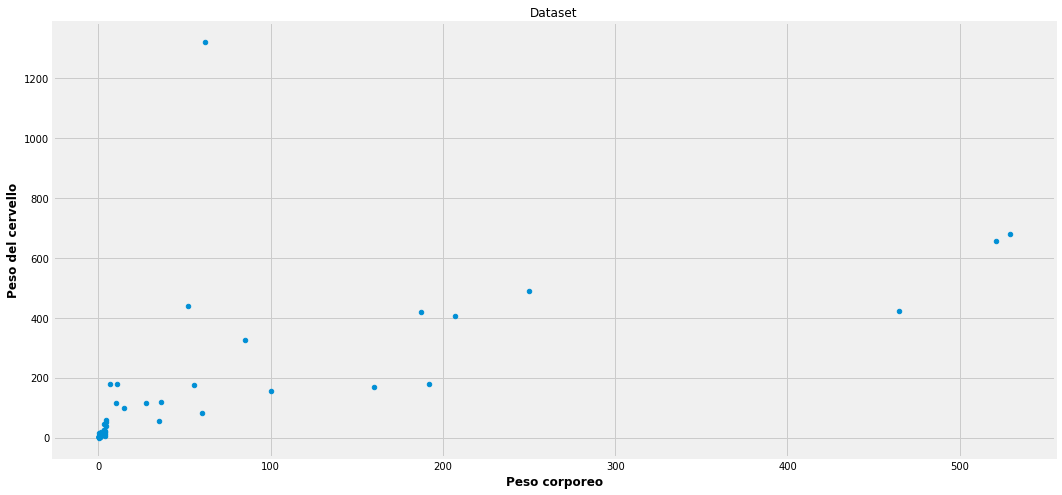

In [11]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
ax.scatter(data.body, data.brain, s=20, marker='o', linewidths=1)
plt.xlabel(u'Peso corporeo', fontsize=12)
plt.ylabel('Peso del cervello', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Dataset', fontsize=12)
plt.show()

Regressione mediante discesa del gradiente on-line

In [12]:
# Estrae dal dataframe gli array X delle features e y dei valori
X, t = np.array(data[['body']]), np.array(data['brain']).reshape((-1,1))

X=normalizza(X)
X = np.column_stack((np.ones(n), X))

Mostriamo la distribuzione dell'errore quadratico medio al variare dei coefficienti

In [13]:
# insieme dei valori considerati per i coefficienti
w0_list = np.linspace(80, 180, 100)
w1_list = np.linspace(80, 180, 100)

# crea una griglia di coppie di valori 
w0, w1 = np.meshgrid(w0_list, w1_list)

# definisce la funzione da calcolare in ogni punto della griglia
def error(v1, v2):
    theta = np.array((v1, v2)).reshape(-1, 1)
    e=(np.dot(X,theta)-t)
    return np.dot(e.T,e)[0,0]/(2*n)

v_error=np.vectorize(error)
e=v_error(w0,w1).T

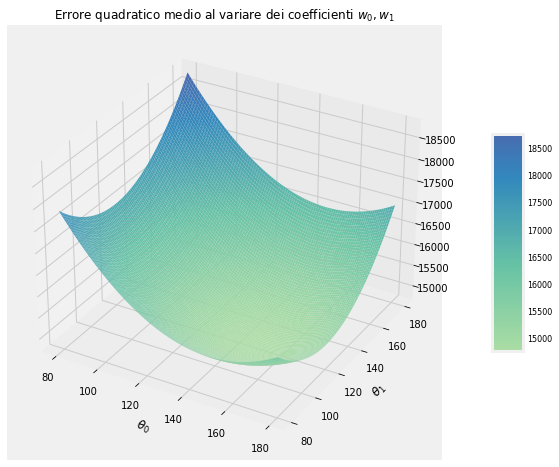

In [14]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(projection='3d')
surf=ax.plot_surface(w0, w1, e, rstride=1, cstride=1, cmap=cmap , linewidth=0, antialiased=True)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)
plt.xlabel(r"$\theta_0$", fontsize=12)
plt.ylabel(r"$\theta_1$", fontsize=12)
plt.title(r"Errore quadratico medio al variare dei coefficienti $w_0,w_1$", fontsize=12)
fig.colorbar(surf, shrink=0.5, aspect=7)
plt.show()

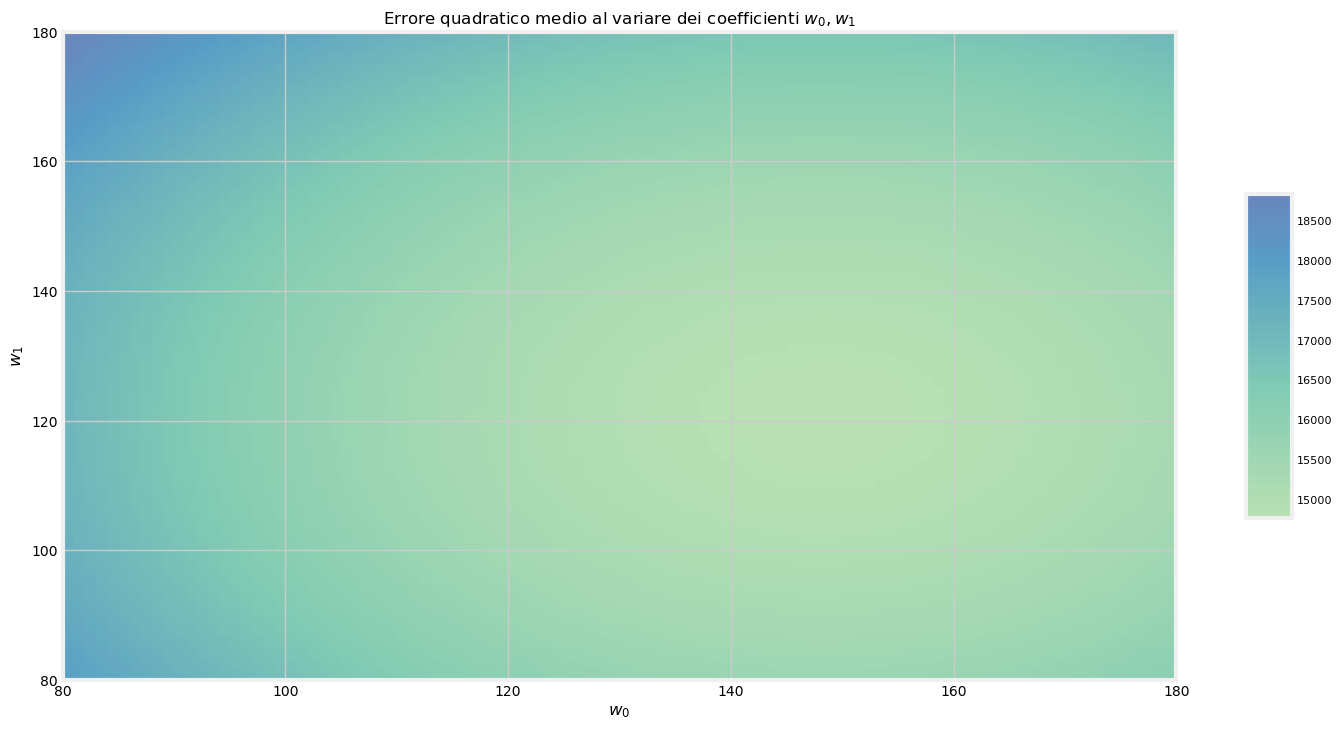

In [14]:
fig = plt.figure(figsize=(16,8))
fig.patch.set_facecolor('white')
ax = fig.gca()
im = plt.imshow(e, origin='lower', cmap=cmap, extent=(w0_list.min(),w0_list.max(),
                w1_list.min(), w1_list.max()), aspect='auto',alpha=.8)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
plt.xlabel(r"$w_0$", fontsize=12)
plt.ylabel(r"$w_1$", fontsize=12)
plt.title(r"Errore quadratico medio al variare dei coefficienti $w_0,w_1$", fontsize=12)
fig.colorbar(im, shrink=0.5, aspect=7)
plt.show()

In [15]:
theta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), t)
e=np.dot(X,theta)-t
c_opt=np.dot(e.T,e)[0,0]/(2*n)
threshold = c_opt+0.05*c_opt

Effettua la regressione mediante discesa del gradiente

In [20]:
# Funzione che applica la ricerca per gradiente memorizzando la sequenza dei costi
def gradiente( X, t, w_init, eta, iterations, n):
    w = np.copy(w_init)
    costs = []
    for i in range(iterations):
        e=np.dot(X,w)-t
        c=np.dot(e.T,e)[0,0]/(2*n)
        dw=np.dot(X.T, e)/n
        w = w-eta*dw
        costs.append(c)
    return costs, w

In [21]:
# Inizializza il vettore dei coefficienti
w_init = np.array([0, 0]).reshape(-1,1)
iterations = 150
etas = [0.01, 0.03, 0.1, 0.3, 0.5, 1]

number_of_iterations = range(1, iterations + 1)

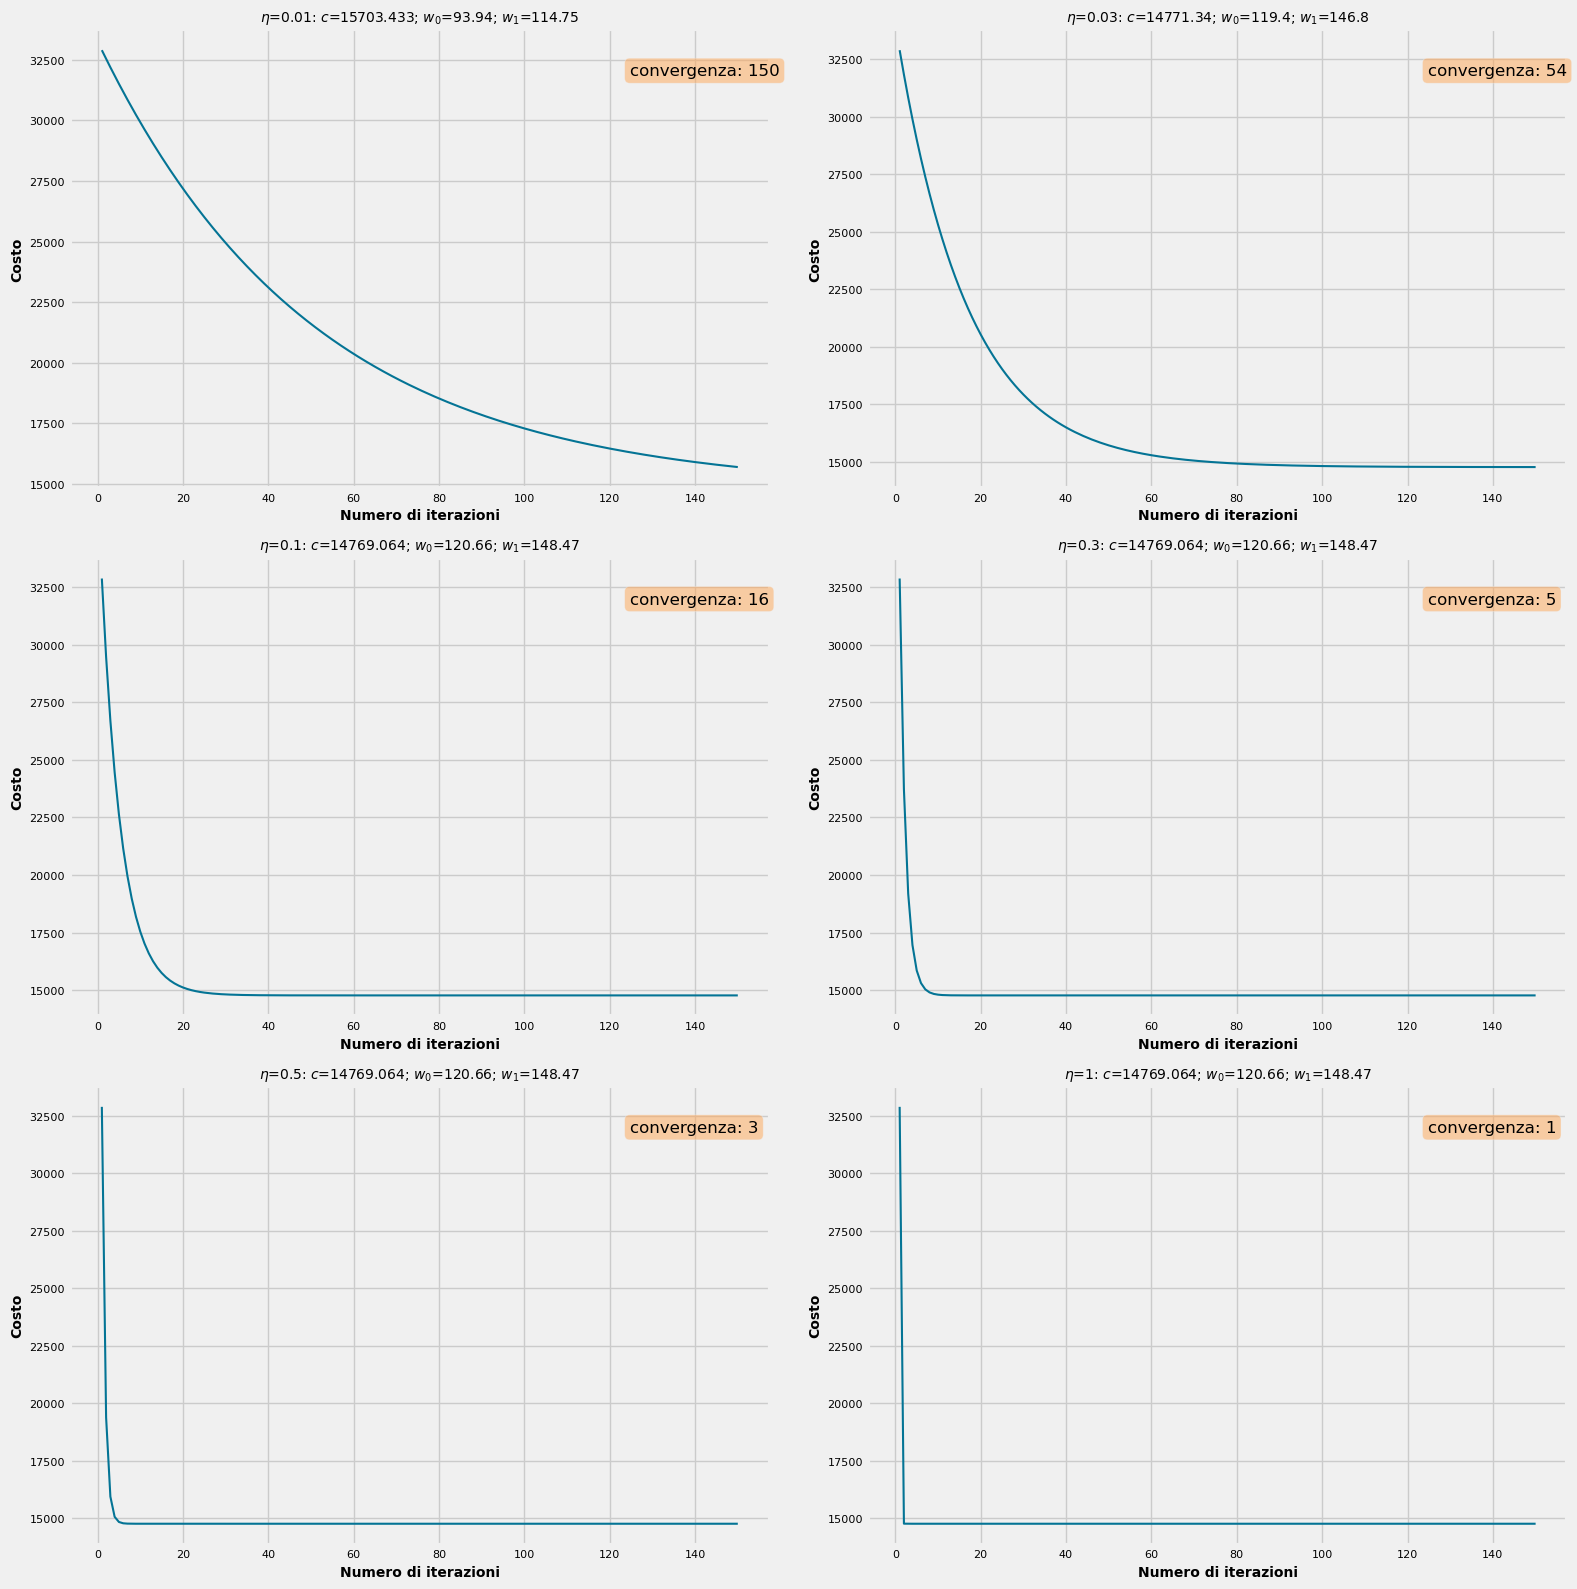

In [23]:
fig = plt.figure(figsize=(16,16))
for c,eta in enumerate(etas):
    costs, w = gradiente(X, t, w_init, eta, iterations, n)
    max_index = np.max(np.where(costs > threshold)[0])+1
    ax = fig.add_subplot(3, 2, c+1)
    ax = fig.gca()
    ax.plot(number_of_iterations, costs, c= colors[1], alpha=1, lw=1.5)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(r'Numero di iterazioni', fontsize=10)
    plt.ylabel(r'Costo', fontsize=10)
    plt.text(0.8, 0.9, 'convergenza: {0:d}'.format(max_index), fontsize=12, 
         transform=ax.transAxes, bbox=bbox_props)
    plt.title(r'$\eta$='+str(eta)+r': $c$='+str(round(costs[-1],3))+r'; $w_0$='+str(round(w[0][0],2))+'; $w_1$='+str(round(w[1][0],2))+'', fontsize=10)
plt.tight_layout()
plt.show()

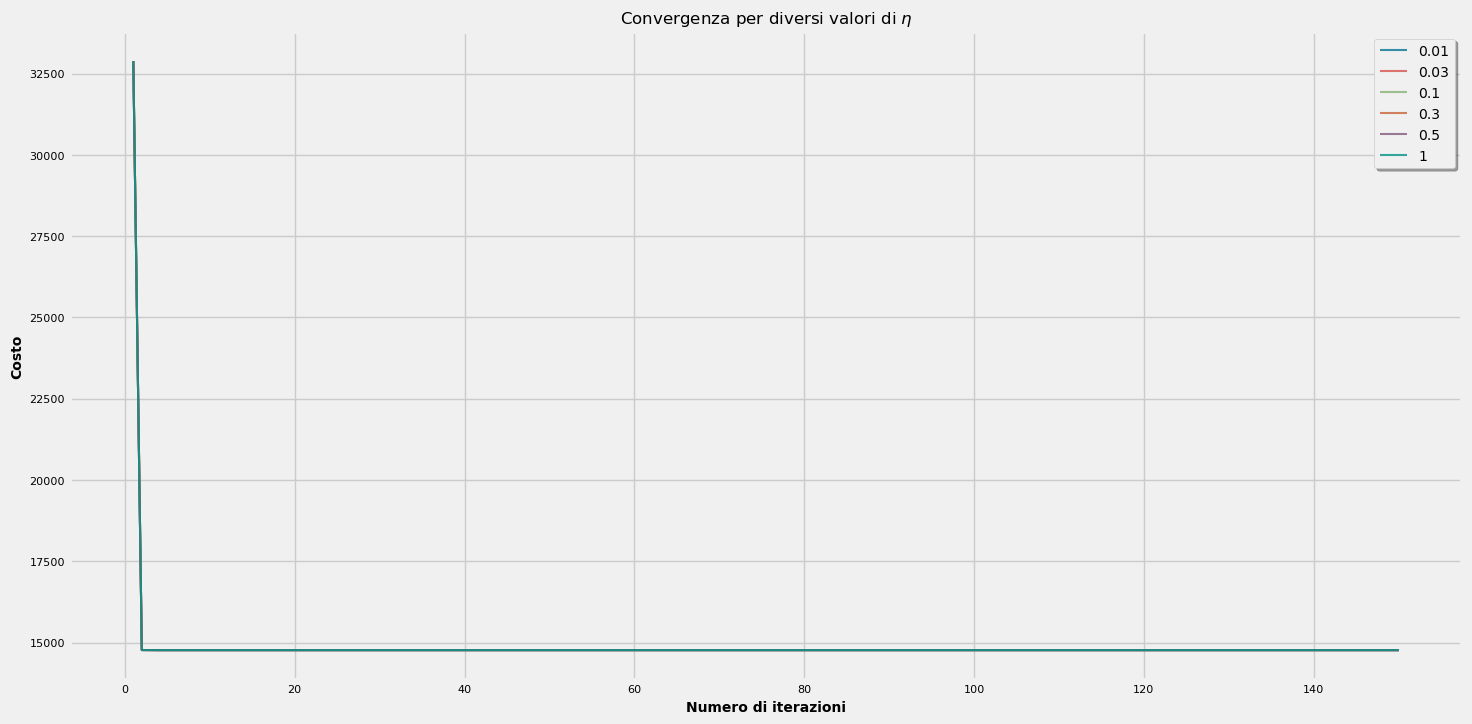

In [24]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
for c,alpha in enumerate(etas):
    costs, w = gradiente(X, t, w_init, eta, iterations, n)
    ax.plot(number_of_iterations, costs, c= colors[c+1], alpha=.8, lw=1.5, label=alpha)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r'Numero di iterazioni', fontsize=10)
plt.ylabel(r'Costo', fontsize=10)
legend = ax.legend(loc='upper right', shadow=True)
plt.title(r'Convergenza per diversi valori di $\eta$', fontsize=12)
plt.show()

In [25]:
def stochastic_gd(X, t, theta_init, eta = 0.01, epochs = 1000):
    theta = theta_init
    theta_history = []
    cost_history = []
    for j in range(epochs):
        for i in range(n):
            e1 = (t[i] - np.dot(X[i,:].reshape(1,-1), theta)).item()/n
            theta = theta + eta * e1 * X[i,:].reshape(-1,1)
        e=np.dot(X,theta)-t
        c=np.dot(e.T,e)[0,0]/(2*n)
        cost_history.append(c)
    cost_history = np.array(cost_history).reshape(-1,1)
    return cost_history, theta

In [26]:
w_init = np.array([0, 0]).reshape(-1,1)
    
epochs = 300
etas = [0.01, 0.03, 0.1, 0.3, 0.5, 1]

number_of_iterations = range(1, epochs + 1)
costs, w = stochastic_gd(X, t, w_init, 0.7, epochs)

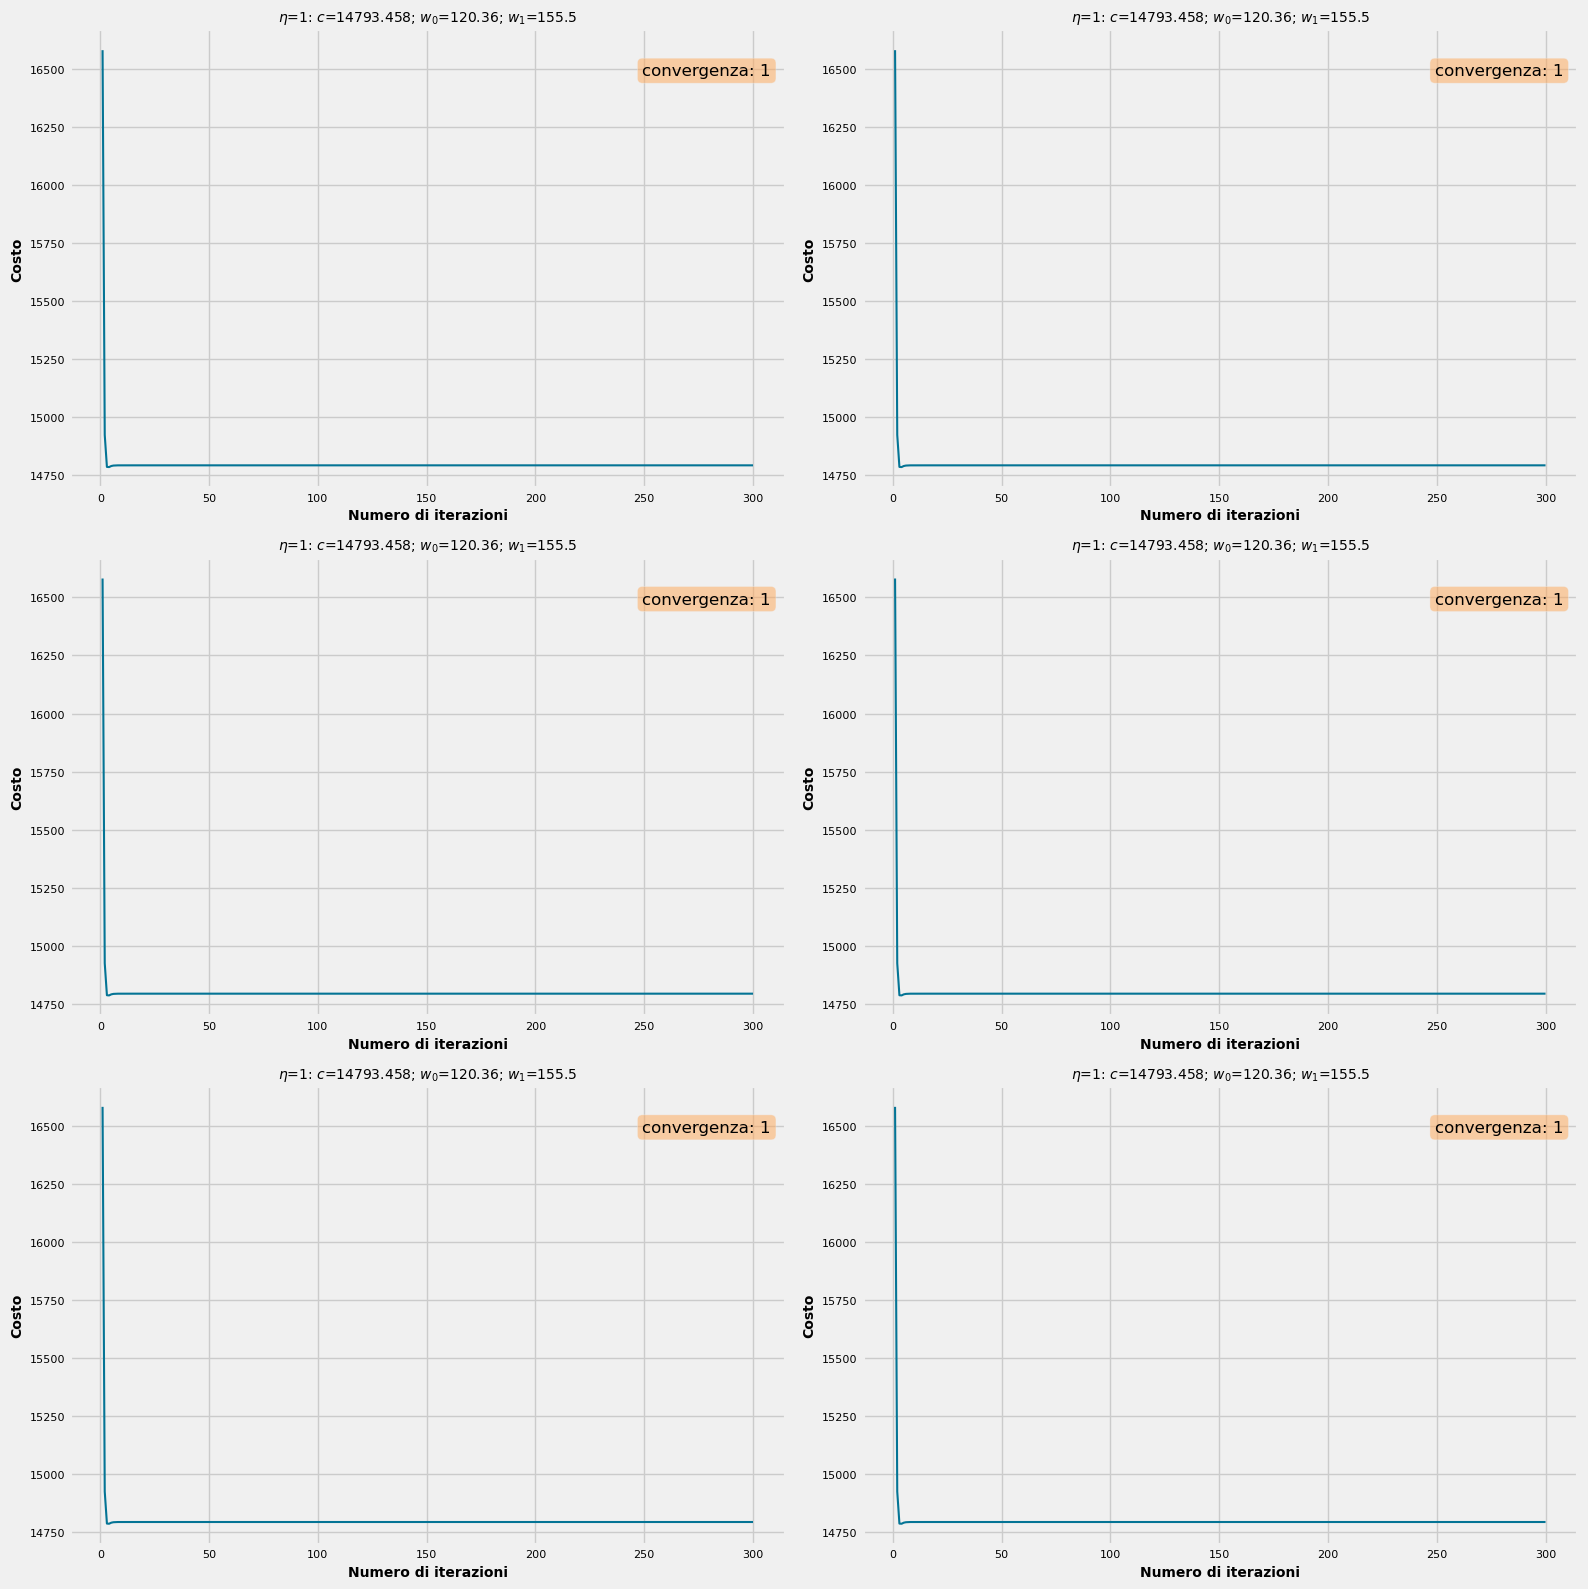

In [27]:
fig = plt.figure(figsize=(16,16))
for c,alpha in enumerate(etas):
    costs, w = stochastic_gd(X, t, w_init, eta, epochs)
    max_index = np.max(np.where(costs > threshold)[0])+1
    ax = fig.add_subplot(3, 2, c+1)
    ax = fig.gca()
    ax.plot(number_of_iterations, costs, c= colors[1], alpha=1, lw=1.5)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(r'Numero di iterazioni', fontsize=10)
    plt.ylabel(r'Costo', fontsize=10)
    plt.text(0.8, 0.9, 'convergenza: {0:d}'.format(max_index), fontsize=12, 
         transform=ax.transAxes, bbox=bbox_props)
    plt.title(r'$\eta$='+str(eta)+r': $c$='+str(round(costs[-1].item(),3))+r'; $w_0$='
              +str(round(w[0][0],2))+'; $w_1$='+str(round(w[1][0],2))+'', fontsize=10)
plt.tight_layout()
plt.show()

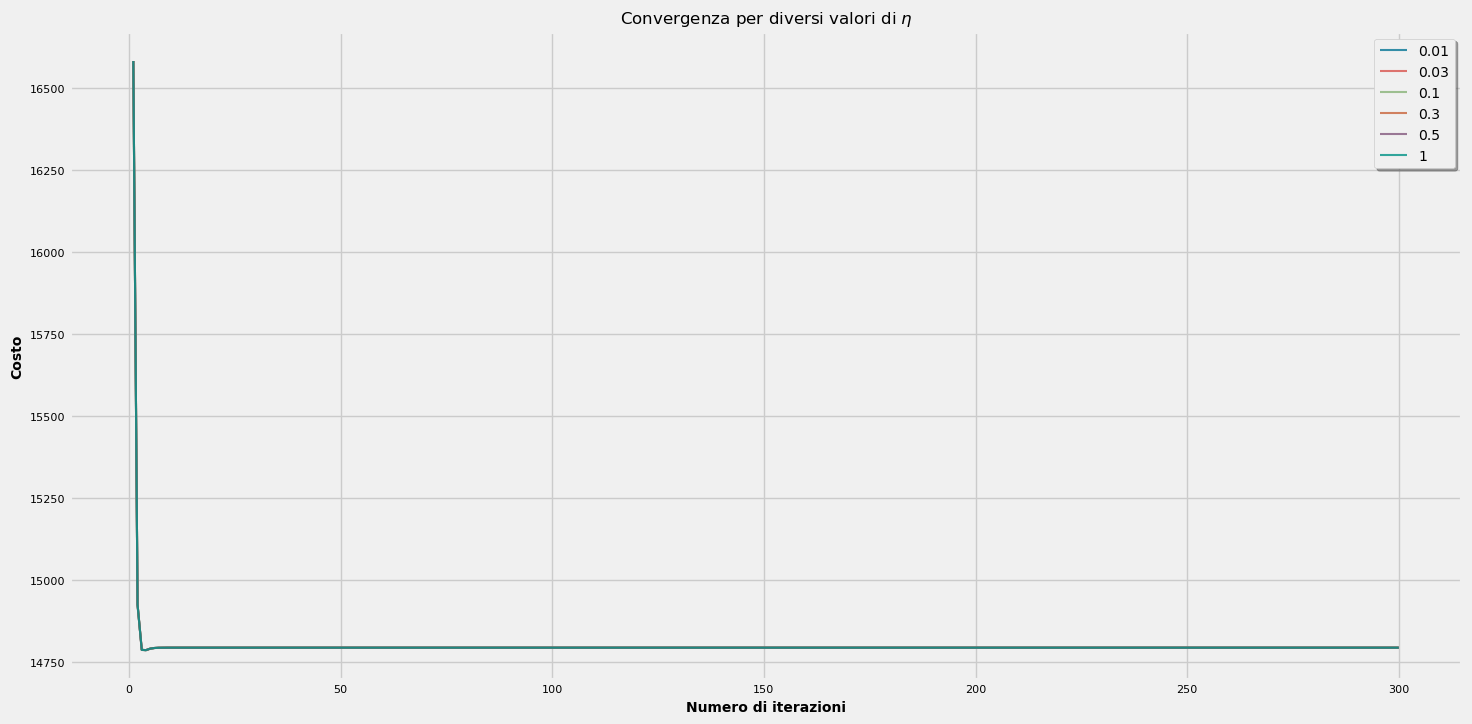

In [28]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
for c,alpha in enumerate(etas):
    costs, w = stochastic_gd(X, t, w_init, eta, epochs)
    ax.plot(number_of_iterations, costs, c= colors[c+1], alpha=.8, lw=1.5, label=alpha)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel(r'Numero di iterazioni', fontsize=10)
plt.ylabel(r'Costo', fontsize=10)
legend = ax.legend(loc='upper right', shadow=True)
plt.title(r'Convergenza per diversi valori di $\eta$', fontsize=12)
plt.show()

In [29]:
def gradiente(X, t, w_init, eta, iterations, n):
    w = np.copy(w_init)
    costs = []
    for i in range(iterations):
        e=np.dot(X,w)-t
        c=np.dot(e.T,e)[0,0]/(2*n)
        dw=np.dot(X.T, e)/n
        w = w-eta*dw
        costs.append(c)
    return costs, w

In [30]:
def momentum_gd(X,t, theta_init, eta = 0.1, gamma = 0.97, epochs = 1000):
    theta = np.copy(theta_init)
    v = np.zeros(2).reshape(-1,1)
    cost_history = []
    for k in range(epochs):    
        e = np.dot(X,theta)-t
        v = gamma*v - eta * np.dot(X.T, e)/n
        theta = theta + v
        cost_history.append(np.dot(e.T,e)[0,0]/(2*n))
    cost_history = np.array(cost_history).reshape(-1,1)
    return cost_history, theta

In [31]:
w_init = np.array([0, 0]).reshape(-1,1)
    
iterations = 150
etas = [0.01, 0.03, 0.1, 0.3, 0.5, 1]

number_of_iterations = range(1, iterations + 1)

In [32]:
gamma=.7

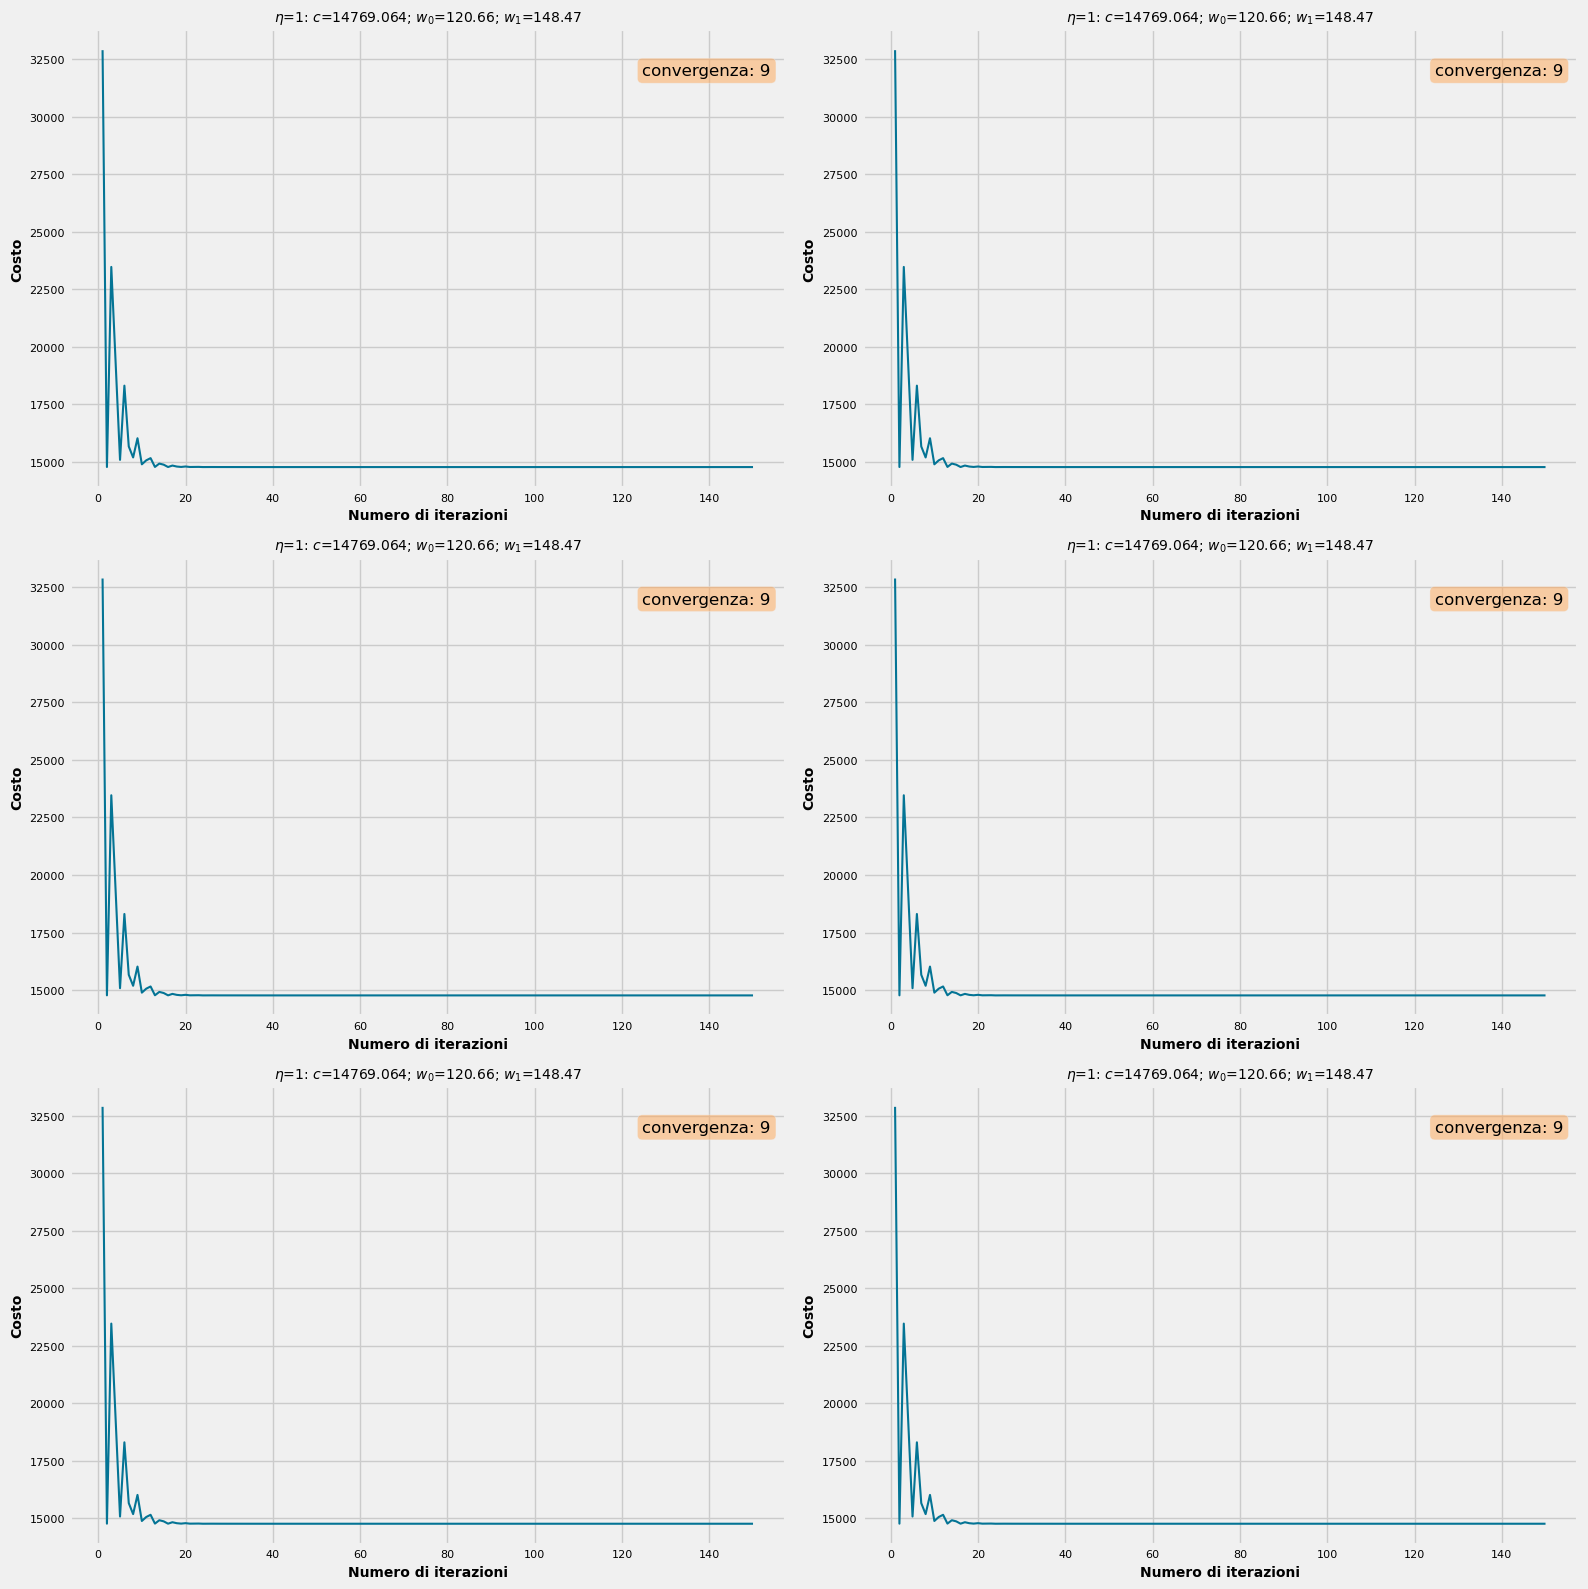

In [33]:
fig = plt.figure(figsize=(16,16))
for c,alpha in enumerate(etas):
    costs, w = momentum_gd(X, t, w_init, eta, gamma, iterations)
    max_index = np.max(np.where(costs > threshold)[0])+1
    ax = fig.add_subplot(3, 2, c+1)
    ax = fig.gca()
    ax.plot(number_of_iterations, costs, c= colors[1], alpha=1, lw=1.5)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(r'Numero di iterazioni', fontsize=10)
    plt.ylabel(r'Costo', fontsize=10)
    plt.text(0.8, 0.9, 'convergenza: {0:d}'.format(max_index), fontsize=12, 
         transform=ax.transAxes, bbox=bbox_props)
    plt.title(r'$\eta$='+str(eta)+r': $c$='+str(round(costs[-1].item(),3))+r'; $w_0$='+str(round(w[0][0],2))+'; $w_1$='+str(round(w[1][0],2))+'', fontsize=10)
plt.tight_layout()
plt.show()